# Imports

In [1]:
# base
import math
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist, squareform
from pandas_plink import read_plink
import statsmodels.api as sm

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

# Data

In [2]:
data_path = pkg_resources.resource_filename("feems", "data/")

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)
n, p = genotypes.shape

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

# construct spatial graph object
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 23.94it/s]


# Fit

In [4]:
def cov_to_dist(S):
    s2 = np.diag(S).reshape(-1, 1)
    ones = np.ones((s2.shape[0], 1))
    D = s2 @ ones.T + ones @ s2.T - 2 * S
    return(D)

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=100.0000000, alpha=0.8354260, converged in 65 iterations, train_loss=2790840.4508851
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=2.0691400, alpha=0.8354260, converged in 82 iterations, train_loss=2767305.7304077
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=0.0428100, alpha=0.8354260, converged in 448 iterations, train_loss=2749772.6032442


Text(0.5, 0, 'fitted distance')

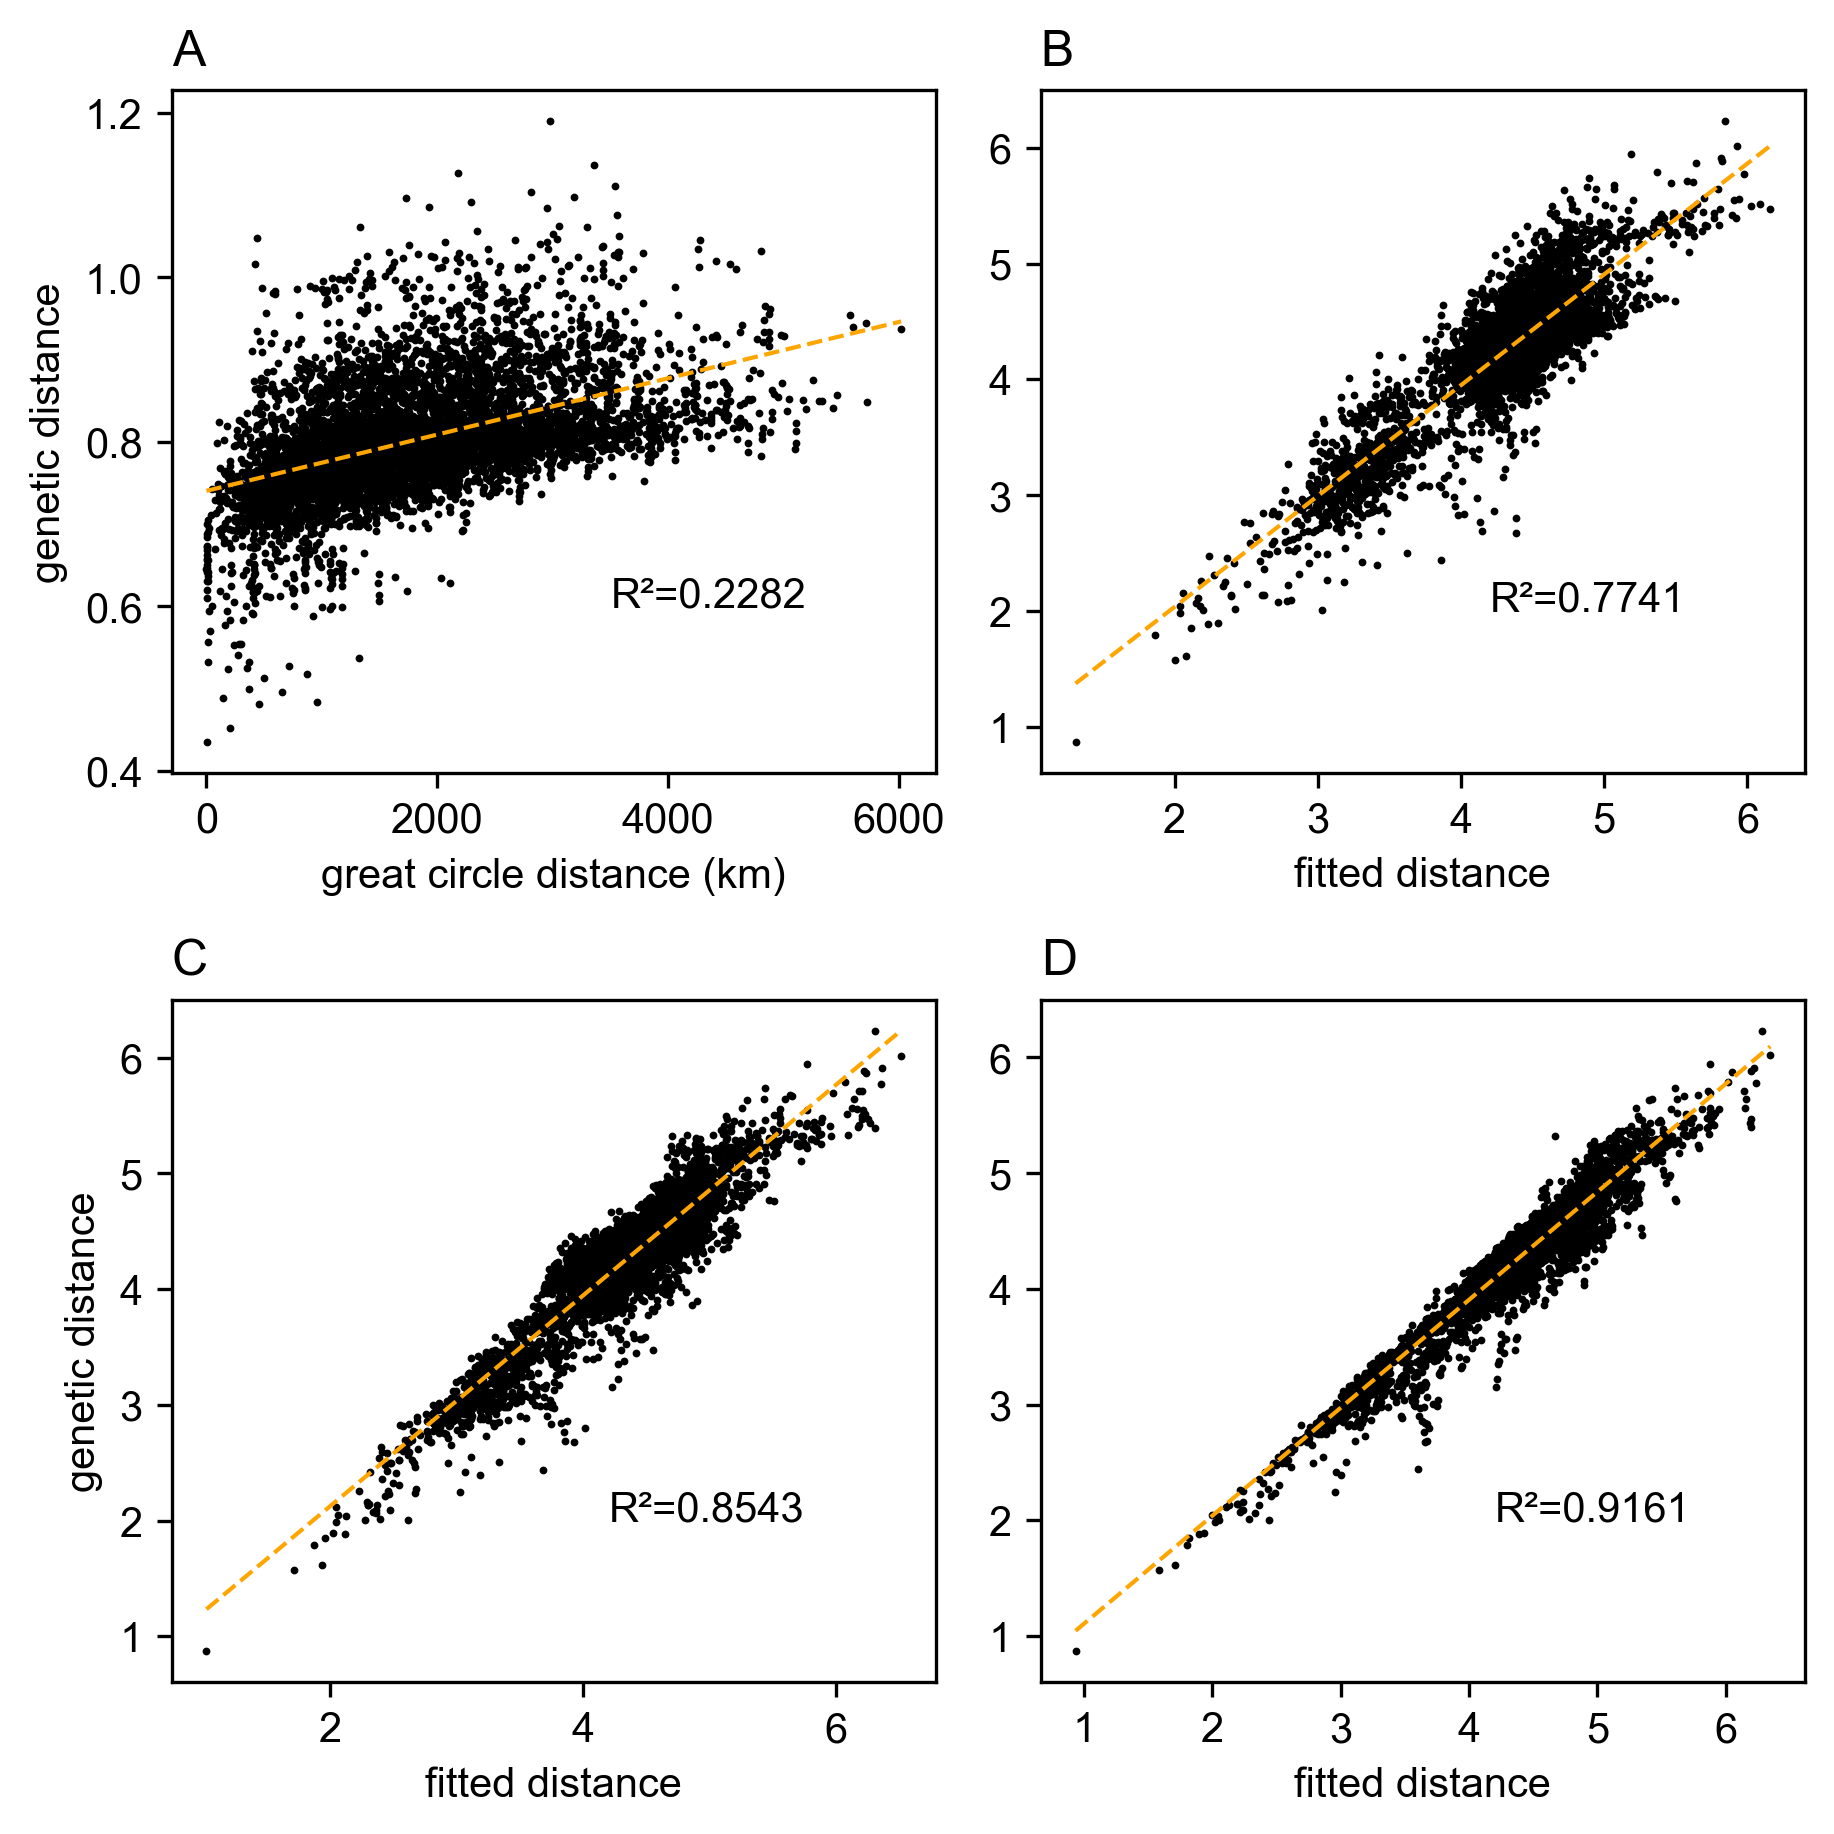

In [5]:
fig = plt.figure(constrained_layout=True, dpi=300, figsize=(6, 6))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# (A)
D_geno = squareform(pdist(genotypes, metric="sqeuclidean")) / p
coord_rad = coord[:,::-1] * math.pi / 180.0
D_geo = haversine_distances(coord_rad) * 6371000/1000
tril_idx = np.tril_indices(n, k=-1)
x = D_geo[tril_idx]
y = D_geno[tril_idx]
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params

ax_00 = fig.add_subplot(spec[0, 0])
ax_00.set_title("A", loc='left')
ax_00.scatter(x, 
              y, 
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(x), np.max(x), 20)
ax_00.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_00.text(3500, .6, "R²={:.4f}".format(res.rsquared))
ax_00.set_xlabel("great circle distance (km)")
ax_00.set_ylabel("genetic distance")

# (B)
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_01 = fig.add_subplot(spec[0, 1])
ax_01.set_title("B", loc='left')
lamb = 100.00
sp_graph.fit(lamb=lamb,
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_01.scatter(fit_dist, 
              emp_dist, 
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_01.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_01.text(4.2, 2, "R²={:.4f}".format(res.rsquared))
ax_01.set_xlabel("fitted distance")

# (C)
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_10 = fig.add_subplot(spec[1, 0])
ax_10.set_title("C", loc='left')
lamb = 2.06914
sp_graph.fit(lamb=lamb,
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_10.scatter(fit_dist,
              emp_dist,
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_10.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_10.text(4.2, 2, "R²={:.4f}".format(res.rsquared))
ax_10.set_xlabel("fitted distance")
ax_10.set_ylabel("genetic distance")

# (D)
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_11 = fig.add_subplot(spec[1, 1])
ax_11.set_title("D", loc='left')
lamb = 0.04281
sp_graph.fit(lamb=lamb,
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_11.scatter(fit_dist,
              emp_dist,
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)
x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_11.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_11.text(4.2, 2, "R²={:.4f}".format(res.rsquared))
ax_11.set_xlabel("fitted distance")

In [7]:
fig.savefig(
    "../output/figures/supp-figure-6-fitted-dist.pdf", bbox_inches="tight"
)